In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random


from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [2]:
def metricas(validacion, prediccion, churm):
    
    print("Exactitud: ", metrics.accuracy_score(validacion, prediccion))
    print("Kappa: ", metrics.cohen_kappa_score(validacion, prediccion))
    
    print(colored('Predicciones de los registros mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[1], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[1], average='macro'))
    
    VP = np.sum(churm[1:2,1:2])
    FN = np.sum(churm[1,0:1])
    specificity = VP/(VP+FN)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[1], average='macro'))
    
    
    print(colored('Predicciones de los registros no mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[0], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[0], average='macro'))
    
    VP = np.sum(churm[0:1,0:1])
    FN = np.sum(churm[0,1:2])
    specificity = VP/(VP+FN)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[0], average='macro'))

In [3]:
def matriz_confusion(validacion, prediccion, cmap):
    print(colored('Matriz de confusión', attrs=['bold']))
    churm = metrics.confusion_matrix(validacion, prediccion)
    plt.imshow(churm, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not_mine','Mine'])
    plt.yticks(tick_marks, ['Not_mine','Mine'])
    return churm

# Importar datos Puros

In [4]:
dataA = pd.read_csv('./data_identificada.csv').drop(['index','Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataA.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
0,400,TCP,0.0,0.0,9.04175,4287.992,65.519,0.0,6750,360512,...,53.0,80.0,1.0,1.0,5.5,32.0,33.0,873.0,not_mine,Does not have


# Preprocesamiento

### Imputación de valores ausentes

In [5]:
punter = pd.concat([dataA['second_sp'],dataA['second_dp'],dataA['third_sp'],dataA['third_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [6]:
punter = pd.DataFrame(values, columns = punter.columns)
dataA['second_sp'] = punter['second_sp']
dataA['second_dp'] = punter['second_dp']
dataA['third_sp'] = punter['third_sp']
dataA['third_dp'] = punter['third_dp']

In [7]:
dataCopyA = dataA
dataA.shape

(4733, 29)

In [8]:
print(colored('Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo', attrs=['bold']))
porcion_no_minera_conjuntoA = dataCopyA[dataCopyA.Type == "not_mine"]
porcion_no_minera_conjuntoA = porcion_no_minera_conjuntoA.sample(n=750)

Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo


In [9]:
dataA = dataA[~dataA.index.isin(porcion_no_minera_conjuntoA.index)]

### OneHotEncoder

In [10]:
data_categoric = dataA[dataA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<3983x11 sparse matrix of type '<class 'numpy.float64'>'
	with 11949 stored elements in Compressed Sparse Row format>

In [11]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,Cryptocurrency_Does not have,Cryptocurrency_Etherium,Cryptocurrency_Litecoin,Cryptocurrency_Monero
1,0,0,1,0,1,0,0,1,0,0,0
2,0,1,0,0,1,0,0,1,0,0,0


### Estructuración

In [12]:
dataA = dataA.drop(data_categoric, axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib'],
      dtype='object')

In [13]:
dataA = pd.concat([dataA,data_dummy], axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP6', 'First_Protocol_TCP', 'First_Protocol_UDP',
       'Type_mine', 'Type_not_mine', 'Cryptocurrency_Bitcash',
       'Cryptocurrency_Bitcoin', 'Cryptocurrency_Does not have',
       'Cryptocurrency_Etherium', 'Cryptocurrency_Litecoin',
       'Cryptocurrency_Monero'],
      dtype='object')

# Árbol de decisión

Mejores caracteristicas del conjunto de datos puros

In [14]:
best_feature_sel = ['#dp', '#sp', 'Avg_bpp', 'first_dp', 'first_sp', 'min_d', 'p1_d',
       'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_ib', 'second_dp',
       'second_sp']

In [15]:
X = dataA[best_feature_sel]
y = dataA['Type_mine']

### Holdout

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)

### Modelo

In [17]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


In [18]:
print(colored('Entreno el modelo', attrs=['bold']))
model.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 3
Número de nodos terminales: 5


[Text(209.25, 475.65000000000003, 'first_sp <= 1887.5\nsamples = 2788\nvalue = [1250, 1538]\nclass = i'),
 Text(139.5, 339.75, 'samples = 1233\nvalue = [1233, 0]\nclass = T'),
 Text(279.0, 339.75, 'p2_ib <= 134.75\nsamples = 1555\nvalue = [17, 1538]\nclass = i'),
 Text(139.5, 203.85000000000002, 'first_sp <= 24470.5\nsamples = 18\nvalue = [16, 2]\nclass = T'),
 Text(69.75, 67.94999999999999, 'samples = 2\nvalue = [0, 2]\nclass = i'),
 Text(209.25, 67.94999999999999, 'samples = 16\nvalue = [16, 0]\nclass = T'),
 Text(418.5, 203.85000000000002, 'first_dp <= 1887.5\nsamples = 1537\nvalue = [1, 1536]\nclass = i'),
 Text(348.75, 67.94999999999999, 'samples = 1\nvalue = [1, 0]\nclass = T'),
 Text(488.25, 67.94999999999999, 'samples = 1536\nvalue = [0, 1536]\nclass = i')]

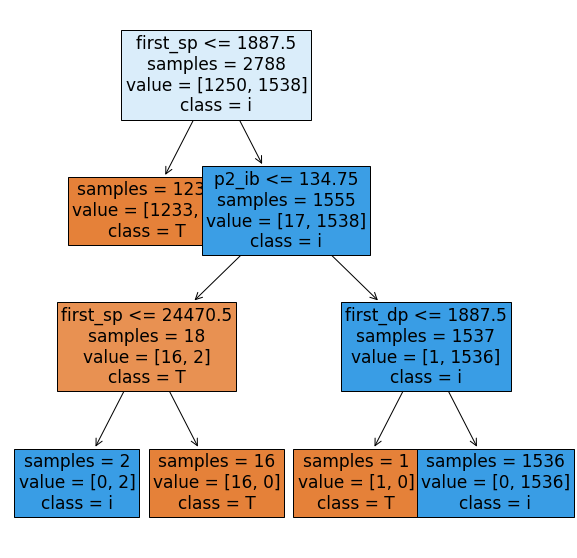

In [19]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [20]:
print(colored('Realizo la predicción del modelo con la porción de prueba', attrs=['bold']))
y_pred = model.predict(X_test)
y_pred

Realizo la predicción del modelo con la porción de prueba


array([1, 0, 0, ..., 1, 1, 1], dtype=uint8)

In [21]:
len(y_pred[y_pred == 0])

500

In [22]:
len(y_pred[y_pred == 1])

695

### Métricas y matriz de confusión

Matriz de confusión


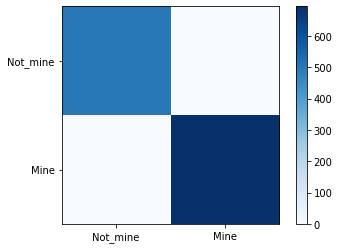

In [23]:
churm = matriz_confusion(y_test, y_pred, plt.cm.Blues)

In [24]:
pd.DataFrame(churm)

,0,1
0,500,1
1,0,694


In [25]:
metricas(y_test, y_pred, churm)

Exactitud:  0.999163179916318
Kappa:  0.9982810578326944
Predicciones de los registros mineros
Precisión:  0.9985611510791367
Recall:  1.0
Especificidad :  1.0
F1-score      :  0.9992800575953923
Predicciones de los registros no mineros
Precisión:  1.0
Recall:  0.998003992015968
Especificidad :  0.998003992015968
F1-score      :  0.9990009990009989


# Experimento 1

In [26]:
print(colored('Importo el conjunto de datos no puros', attrs=['bold']))
dataB = pd.read_csv('./data_no_identificada.csv').drop(['index','Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataB.columns

Importo el conjunto de datos no puros


Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type', 'Cryptocurrency'],
      dtype='object')

In [27]:
porcion_no_minera_conjuntoA.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type', 'Cryptocurrency'],
      dtype='object')

In [28]:
dataB = pd.concat([dataB[dataB.Type == 'mine'],porcion_no_minera_conjuntoA], axis = 0)

In [29]:
dataB.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type', 'Cryptocurrency'],
      dtype='object')

In [30]:
dataC = dataB

In [42]:
print(colored('Valores faltantes del conjunto no puro', attrs=['bold']))
dataB.isnull().sum()

Valores faltantes del conjunto no puro


Netflows             0
First_Protocol       0
p1_d                 0
p2_d                 0
p3_d                 0
duration             0
max_d                0
min_d                0
#packets             0
Avg_bps              0
Avg_pps              0
Avg_bpp              0
#Bytes               0
#sp                  0
#dp                  0
first_sp             0
second_sp         1645
third_sp          1645
first_dp             0
second_dp         1645
third_dp          1645
p1_ip                0
p2_ip                0
p3_ip                0
p1_ib                0
p2_ib                0
p3_ib                0
Type                 0
Cryptocurrency       0
dtype: int64

### Imputar valores

In [32]:
punter = pd.concat([dataB['second_sp'],dataB['third_sp'],dataB['second_dp'],dataB['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
values = imputer.fit_transform(punter)

In [33]:
punter = pd.DataFrame(values, columns = punter.columns)
dataB['second_sp'] = punter['second_sp']
dataB['second_dp'] = punter['second_dp']
dataB['third_sp'] = punter['third_sp']
dataB['third_dp'] = punter['third_dp']

In [47]:
dataB = dataB.dropna()

In [48]:
X = dataB[best_feature_sel]
y = dataB['Type'].replace({'mine':1,'not_mine':0})

In [49]:
y_pred = model.predict(X)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

Matriz de confusión


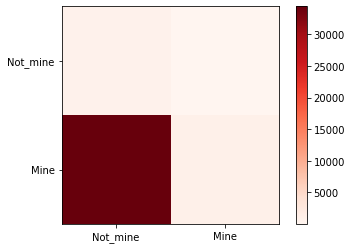

In [50]:
churm = matriz_confusion(y, y_pred, plt.cm.Reds)

In [51]:
pd.DataFrame(churm)

,0,1
0,748,2
1,34440,968


In [52]:
metricas(y, y_pred, churm)

Exactitud:  0.047458377122628466
Kappa:  0.0010510994025463294
Predicciones de los registros mineros
Precisión:  0.9979381443298969
Recall:  0.027338454586534118
Especificidad :  0.027338454586534118
F1-score      :  0.05321897850349113
Predicciones de los registros no mineros
Precisión:  0.021257246788677957
Recall:  0.9973333333333333
Especificidad :  0.9973333333333333
F1-score      :  0.04162724692526017


# Experimento 2

In [53]:
print(colored('Caracteristicas del conjunto de datos puro', attrs=['bold']))
print(best_feature_sel)

Caracteristicas del conjunto de datos puro
['#dp', '#sp', 'Avg_bpp', 'first_dp', 'first_sp', 'min_d', 'p1_d', 'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_ib', 'second_dp', 'second_sp']


In [54]:
print(colored('Caracteristicas del conjunto de datos no puro', attrs=['bold']))
best_feature_noPure = ['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps',
       'Avg_pps', 'duration', 'first_dp', 'p2_d', 'p2_ib', 'p3_d',
       'p3_ip', 'second_dp', 'second_sp', 'third_dp', 'third_sp']
print(best_feature_noPure)

Caracteristicas del conjunto de datos no puro
['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps', 'Avg_pps', 'duration', 'first_dp', 'p2_d', 'p2_ib', 'p3_d', 'p3_ip', 'second_dp', 'second_sp', 'third_dp', 'third_sp']


In [55]:
print(colored('Combino las caracteristicas', attrs=['bold']))
bestFeature = np.concatenate([best_feature_sel,best_feature_noPure])
bestFeature = np.unique(bestFeature)
bestFeature

Combino las caracteristicas


array(['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps',
       'Avg_pps', 'duration', 'first_dp', 'first_sp', 'min_d', 'p1_d',
       'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_d', 'p3_ib', 'p3_ip',
       'second_dp', 'second_sp', 'third_dp', 'third_sp'], dtype='<U9')

In [63]:
print(colored('Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos', attrs=['bold']))
porcion_minera_conjuntoB = dataB[dataB.Type == "mine"]
porcion_minera_conjuntoB = porcion_minera_conjuntoB.sample(n=dataCopyA[dataCopyA.Type == "mine"].shape[0])

Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos


In [59]:
print(colored('Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros', attrs=['bold']))


Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros


In [64]:
data_final = pd.concat([dataA, porcion_minera_conjuntoB], axis = 0)
data_final.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(6215, 40)

In [68]:
print(colored('Aleatoriedad', attrs=['bold']))
data_final = data_final.reset_index()
indices = list(data_final.index)
random.shuffle(indices)
data_final = data_final.reindex(indices)
data_final.head()

Aleatoriedad


,index,#Bytes,#dp,#packets,#sp,Avg_bpp,Avg_bps,Avg_pps,Cryptocurrency,Cryptocurrency_Bitcash,...,p2_d,p2_ib,p2_ip,p3_d,p3_ib,p3_ip,second_dp,second_sp,third_dp,third_sp
1929,2324,26272,2,191,2,137,1313,1,NaN,0.0,...,79.056,2539.0,46.0,150.55000,8369.5,89.00,58780.0,58780.0,443.0,123.0
2570,3075,25899,2,194,2,133,1218,1,NaN,0.0,...,29.975,1297.5,21.0,40.01025,4224.0,24.25,58780.0,58780.0,443.0,123.0
2636,3161,59334,2,430,2,137,1356,1,NaN,0.0,...,349.950,29667.0,215.0,349.95000,39810.5,221.50,58780.0,58780.0,443.0,123.0
3974,4724,28676,2,217,2,132,1233,1,NaN,0.0,...,11.084,801.0,7.0,37.33425,1953.5,26.00,64790.0,64790.0,443.0,123.0
4725,10688,1324,3,12,4,110,63,0,Unidentified,NaN,...,3.113,338.5,3.5,6.01875,503.0,4.00,34560.0,55817.0,5353.0,1900.0


In [70]:
data_final.replace({np.nan:0})

,index,#Bytes,#dp,#packets,#sp,Avg_bpp,Avg_bps,Avg_pps,Cryptocurrency,Cryptocurrency_Bitcash,...,p2_d,p2_ib,p2_ip,p3_d,p3_ib,p3_ip,second_dp,second_sp,third_dp,third_sp
1929,2324,26272,2,191,2,137,1313,1,0,0.0,...,79.0560,2539.0,46.0,150.55000,8369.50,89.00,58780.0,58780.0,443.0,123.0
2570,3075,25899,2,194,2,133,1218,1,0,0.0,...,29.9750,1297.5,21.0,40.01025,4224.00,24.25,58780.0,58780.0,443.0,123.0
2636,3161,59334,2,430,2,137,1356,1,0,0.0,...,349.9500,29667.0,215.0,349.95000,39810.50,221.50,58780.0,58780.0,443.0,123.0
3974,4724,28676,2,217,2,132,1233,1,0,0.0,...,11.0840,801.0,7.0,37.33425,1953.50,26.00,64790.0,64790.0,443.0,123.0
4725,10688,1324,3,12,4,110,63,0,Unidentified,0.0,...,3.1130,338.5,3.5,6.01875,503.00,4.00,34560.0,55817.0,5353.0,1900.0
250,297,10147,2,31,2,327,372,0,0,0.0,...,217.6520,5073.5,15.5,217.67250,7281.25,16.25,56490.0,56490.0,443.0,123.0
5310,17167,6534,5,128,2,51,92,0,Unidentified,0.0,...,0.0000,32.0,1.0,0.00000,40.00,1.00,8082.0,5353.0,1281.0,57135.0
5702,24744,18242,7,156,5,116,256,0,Unidentified,0.0,...,0.0000,40.0,1.0,0.00000,300.00,1.00,1281.0,49159.0,45560.0,546.0
5918,5041,955,3,22,1,43,27,0,Unidentified,0.0,...,0.0000,32.0,1.0,0.00000,32.00,1.00,1281.0,49604.0,49604.0,45560.0
497,592,53861,2,398,2,135,1298,1,0,0.0,...,331.7440,26930.5,199.0,331.75400,35898.75,205.00,58780.0,58780.0,443.0,123.0


### OneHotEncoder

In [71]:
data_categoric = data_final.select_dtypes(['object'])
one_hot =  OneHotEncoder()
one_hot.fit_transform(data_categoric)
dataDummy = pd.get_dummies(data_categoric)
data_final = data_final.drop(data_categoric.columns, axis = 1)
data_final = pd.concat([data_final,dataDummy],axis = 1)
data_final.head(1)

ValueError: Input contains NaN

### Modelo

In [72]:
X = data_final[bestFeature]
y = data_final['Type_mine']

In [73]:
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [74]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
K_fold = KFold(n_splits = 10)

In [ ]:
resultados_train = []
resultados_test = []
predicciones = []
scores = []
modelos = []


for result in K_fold.split(X):
    resultados_train.append(result[0])
    resultados_test.append(result[1])
    X_train = X.iloc[result[0]]
    X_test =  X.iloc[result[1]]
    y_train =  y.iloc[result[0]]
    y_test =  y.iloc[result[1]]
    model = model.fit(X_train,y_train)
    modelos.append(model)
    predic = model.predict(X_test)
    predicciones.append(predic)
    scores.append(model.score(X_test, y_test))

In [ ]:
scores

In [ ]:
churm = matriz_confusion(y.iloc[resultados_test[0]], predicciones[0], plt.cm.OrRd)

In [ ]:
pd.DataFrame(churm)

In [ ]:
metricas(y.iloc[resultados_test[0]], predicciones[0], churm)

### Prueba final

In [ ]:
dataRestanteC = dataC[~dataC['index'].isin(porcion_no_minera_conjuntoA.index)]

In [ ]:
dataRestanteC = dataC[~dataC['index'].isin(porcion_minera_conjuntoB)]

In [ ]:
X_p = dataRestanteC[bestFeature]
y_p = dataRestanteC['Type'].replace({'mine':1,'not_mine':0})

In [ ]:
y_pred_proba = modelos[0].predict(X_p)

In [ ]:
churm = matriz_confusion(y_p, y_pred_proba, plt.cm.Greens)

In [ ]:
pd.DataFrame(churm)

In [ ]:
metricas(y_p, y_pred_proba, churm)

In [ ]:
dddd

In [ ]:
y_pred_proba = model.predict_proba(X_test)

In [ ]:
lr_probs = y_pred_proba[:,1]

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]

In [ ]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_auc

In [ ]:
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
lr_auc

In [ ]:
#Sumo los scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Treeb: ROC AUC=%.3f' % (lr_auc))

In [ ]:
ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)

In [ ]:
#Plot la roc curva para el modelo
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Holdaunt 70% pero debo hacer una validadci{on cruzada en este conjunto de entrenamiento (Puros), de este cruz validation saldra un modelo, y lo testeo con el 30%, con este porcentaje, le saco las metricas